# EduSpend: Final Models Development
## Affordability Classifier & University Clustering

**Project:** EduSpend - Global Higher-Education Cost Analytics & Planning  
**Author:** yan-cotta  
**Date:** June 27, 2025  
**Phase:** Final Models - Classifier & Clustering  

### Notebook Overview
This notebook implements the final two models required for the EduSpend project:
1. **Affordability Classifier**: RandomForestClassifier to predict affordability tiers
2. **University Clustering**: KMeans clustering to group universities by cost patterns

### Goals
1. Load and prepare the education cost dataset
2. Create and evaluate an affordability classification model
3. Implement university clustering based on cost features
4. Save the final labeled dataset for downstream applications

## Step 1: Import Required Libraries

We'll import the necessary libraries for data processing, modeling, and evaluation.

In [1]:
# Import data manipulation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    f1_score, 
    confusion_matrix,
    silhouette_score
)

# Import plotting libraries
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set random seed for reproducibility
np.random.seed(42)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## Step 2: Load and Explore the Dataset

We'll load the education cost dataset and examine its structure to understand the available features.

In [2]:
# Load the dataset
# First, try to load the cleaned dataset, fallback to original if not available
try:
    df = pd.read_csv('data/cleaned_education_costs.csv')
    print("✅ Loaded cleaned_education_costs.csv")
except FileNotFoundError:
    try:
        df = pd.read_csv('data/International_Education_Costs.csv')
        print("✅ Loaded International_Education_Costs.csv")
    except FileNotFoundError:
        print("❌ No dataset found. Please ensure the data file is in the data/ directory.")
        raise

# Display basic information about the dataset
print(f"\n📊 Dataset Shape: {df.shape}")
print(f"\n📋 Columns: {list(df.columns)}")

# Display first few rows
print("\n🔍 First 5 rows:")
df.head()

✅ Loaded International_Education_Costs.csv

📊 Dataset Shape: (907, 14)

📋 Columns: ['Country', 'City', 'University', 'Program', 'Level', 'Duration_Years', 'Tuition_USD', 'Living_Cost_Index', 'Rent_USD', 'Visa_Fee_USD', 'Insurance_USD', 'Exchange_Rate', 'TCA', 'Affordability_Tier']

🔍 First 5 rows:


,Country,City,University,Program,Level,Duration_Years,Tuition_USD,Living_Cost_Index,Rent_USD,Visa_Fee_USD,Insurance_USD,Exchange_Rate,TCA,Affordability_Tier
0,USA,Cambridge,Harvard University,Computer Science,Master,2.0,55400,83.5,2200,160,1500,1.00,83460,High
1,UK,London,Imperial College London,Data Science,Master,1.0,41200,75.8,1800,485,800,0.79,64085,High
2,Canada,Toronto,University of Toronto,Business Analytics,Master,2.0,38500,72.5,1600,235,900,1.35,58835,High
3,Australia,Melbourne,University of Melbourne,Engineering,Master,2.0,42000,71.2,1400,450,650,1.52,59900,High
4,Germany,Munich,Technical University of Munich,Mechanical Engineering,Master,2.0,500,70.5,1100,75,550,0.92,14325,Medium


In [3]:
# Check for missing values
print("🔍 Missing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Display data types
print("\n📊 Data Types:")
print(df.dtypes)

# Display basic statistics
print("\n📈 Dataset Summary:")
df.describe()

🔍 Missing Values:
Series([], dtype: int64)

📊 Data Types:
Country                object
City                   object
University             object
Program                object
Level                  object
Duration_Years        float64
Tuition_USD             int64
Living_Cost_Index     float64
Rent_USD                int64
Visa_Fee_USD            int64
Insurance_USD           int64
Exchange_Rate         float64
TCA                     int64
Affordability_Tier     object
dtype: object

📈 Dataset Summary:


,Duration_Years,Tuition_USD,Living_Cost_Index,Rent_USD,Visa_Fee_USD,Insurance_USD,Exchange_Rate,TCA
count,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000
mean,2.836825,16705.016538,64.437486,969.206174,211.396913,700.077178,623.000695,29246.964719
std,0.945449,16582.385275,14.056333,517.154752,143.435740,320.374875,3801.746134,21798.025789
min,1.000000,0.000000,27.800000,150.000000,40.000000,200.000000,0.150000,3100.000000
25%,2.000000,2850.000000,56.300000,545.000000,100.000000,450.000000,0.920000,11475.000000
50%,3.000000,7500.000000,67.500000,900.000000,160.000000,650.000000,1.350000,18590.000000
75%,4.000000,31100.000000,72.200000,1300.000000,240.000000,800.000000,7.150000,46495.000000
max,5.000000,62000.000000,122.400000,2500.000000,490.000000,1500.000000,42150.000000,93660.000000


## Step 3: Data Preparation and Feature Engineering

We'll prepare the data by calculating TCA (if not present) and creating the affordability tiers.

In [4]:
# Create TCA (Total Cost of Attendance) if not present
if 'TCA' not in df.columns:
    print("🔧 Creating TCA column...")
    # Calculate TCA as sum of all cost components
    cost_columns = ['Tuition_USD', 'Rent_USD', 'Visa_Fee_USD', 'Insurance_USD']
    
    # Handle missing values by filling with 0
    for col in cost_columns:
        if col in df.columns:
            df[col] = df[col].fillna(0)
    
    # Calculate TCA
    df['TCA'] = df['Tuition_USD'].fillna(0)
    
    if 'Rent_USD' in df.columns:
        # Multiply rent by 12 for annual cost
        df['TCA'] += df['Rent_USD'].fillna(0) * 12
    
    if 'Visa_Fee_USD' in df.columns:
        df['TCA'] += df['Visa_Fee_USD'].fillna(0)
    
    if 'Insurance_USD' in df.columns:
        df['TCA'] += df['Insurance_USD'].fillna(0)
    
    print(f"✅ TCA column created with range: ${df['TCA'].min():,.0f} - ${df['TCA'].max():,.0f}")
else:
    print("✅ TCA column already exists")

# Display TCA statistics
print(f"\n📊 TCA Statistics:")
print(f"Mean TCA: ${df['TCA'].mean():,.0f}")
print(f"Median TCA: ${df['TCA'].median():,.0f}")
print(f"Standard Deviation: ${df['TCA'].std():,.0f}")

✅ TCA column already exists

📊 TCA Statistics:
Mean TCA: $29,247
Median TCA: $18,590
Standard Deviation: $21,798


In [5]:
# Create affordability tiers based on TCA quantiles
if 'affordability_tier' not in df.columns and 'Affordability_Tier' not in df.columns:
    print("🔧 Creating affordability_tier column...")
    
    # Calculate quantiles
    q33 = df['TCA'].quantile(0.33)
    q67 = df['TCA'].quantile(0.67)
    
    print(f"💰 TCA Quantiles:")
    print(f"33rd percentile: ${q33:,.0f}")
    print(f"67th percentile: ${q67:,.0f}")
    
    # Create affordability tiers
    def assign_affordability_tier(tca):
        if tca <= q33:
            return 'Low'
        elif tca <= q67:
            return 'Medium'
        else:
            return 'High'
    
    df['affordability_tier'] = df['TCA'].apply(assign_affordability_tier)
    
    print("✅ Affordability tiers created")
elif 'Affordability_Tier' in df.columns:
    df['affordability_tier'] = df['Affordability_Tier']
    print("✅ Using existing Affordability_Tier column")
else:
    print("✅ affordability_tier column already exists")

# Display affordability tier distribution
print(f"\n📊 Affordability Tier Distribution:")
tier_counts = df['affordability_tier'].value_counts()
for tier, count in tier_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{tier}: {count} ({percentage:.1f}%)")

✅ Using existing Affordability_Tier column

📊 Affordability Tier Distribution:
Medium: 303 (33.4%)
Low: 303 (33.4%)
High: 301 (33.2%)


## Step 4: Affordability Classification Model

We'll create a RandomForestClassifier to predict affordability tiers based on the available features.

In [6]:
# Prepare features for classification
print("🔧 Preparing features for classification...")

# Select relevant features for classification (excluding TCA since it's used to create the target)
feature_columns = []
categorical_features = []
numerical_features = []

# Add categorical features
for col in ['Country', 'City', 'Program', 'Level']:
    if col in df.columns:
        categorical_features.append(col)
        feature_columns.append(col)

# Add numerical features (excluding TCA)
for col in ['Duration_Years', 'Living_Cost_Index', 'Exchange_Rate', 'Tuition_USD', 'Rent_USD', 'Visa_Fee_USD', 'Insurance_USD']:
    if col in df.columns:
        numerical_features.append(col)
        feature_columns.append(col)

print(f"📋 Selected Features:")
print(f"Categorical: {categorical_features}")
print(f"Numerical: {numerical_features}")

# Create feature matrix
X = df[feature_columns].copy()
y = df['affordability_tier'].copy()

print(f"\n📊 Feature Matrix Shape: {X.shape}")
print(f"📊 Target Variable Shape: {y.shape}")

🔧 Preparing features for classification...
📋 Selected Features:
Categorical: ['Country', 'City', 'Program', 'Level']
Numerical: ['Duration_Years', 'Living_Cost_Index', 'Exchange_Rate', 'Tuition_USD', 'Rent_USD', 'Visa_Fee_USD', 'Insurance_USD']

📊 Feature Matrix Shape: (907, 11)
📊 Target Variable Shape: (907,)


In [7]:
# Handle categorical variables with one-hot encoding
print("🔧 Encoding categorical variables...")

# Fill missing values
for col in numerical_features:
    X[col] = X[col].fillna(X[col].median())

for col in categorical_features:
    X[col] = X[col].fillna('Unknown')

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=categorical_features, prefix=categorical_features)

print(f"✅ Encoded feature matrix shape: {X_encoded.shape}")
print(f"📋 Final features: {len(X_encoded.columns)} total features")

# Display first few columns
print(f"\n🔍 Sample encoded features: {list(X_encoded.columns[:10])}...")

🔧 Encoding categorical variables...
✅ Encoded feature matrix shape: (907, 729)
📋 Final features: 729 total features

🔍 Sample encoded features: ['Duration_Years', 'Living_Cost_Index', 'Exchange_Rate', 'Tuition_USD', 'Rent_USD', 'Visa_Fee_USD', 'Insurance_USD', 'Country_Algeria', 'Country_Argentina', 'Country_Australia']...


In [8]:
# Split the data for training and testing
print("🔧 Splitting data into train and test sets...")

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"📊 Training set: {X_train.shape}")
print(f"📊 Test set: {X_test.shape}")

# Check class distribution in train and test sets
print(f"\n📊 Training set class distribution:")
print(y_train.value_counts(normalize=True).round(3))

print(f"\n📊 Test set class distribution:")
print(y_test.value_counts(normalize=True).round(3))

🔧 Splitting data into train and test sets...
📊 Training set: (725, 729)
📊 Test set: (182, 729)

📊 Training set class distribution:
affordability_tier
Medium    0.334
Low       0.334
High      0.332
Name: proportion, dtype: float64

📊 Test set class distribution:
affordability_tier
Low       0.335
Medium    0.335
High      0.330
Name: proportion, dtype: float64


In [9]:
# Train the RandomForestClassifier
print("🚀 Training RandomForestClassifier...")

# Initialize the classifier
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Train the model
rf_classifier.fit(X_train, y_train)

print("✅ RandomForestClassifier training completed!")

# Make predictions
y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)

print(f"📊 Predictions completed for {len(y_test)} samples")

🚀 Training RandomForestClassifier...
✅ RandomForestClassifier training completed!
📊 Predictions completed for 182 samples


In [10]:
# Evaluate the classifier
print("📊 Evaluating Affordability Classifier Performance")
print("=" * 50)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f"🎯 Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"🎯 Macro F1-Score: {f1_macro:.4f}")

# Classification report
print(f"\n📋 Detailed Classification Report:")
print(classification_report(y_test, y_pred))

# Cross-validation scores
print(f"\n🔄 Cross-Validation Performance:")
cv_scores = cross_val_score(rf_classifier, X_encoded, y, cv=5, scoring='accuracy')
print(f"CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

cv_f1_scores = cross_val_score(rf_classifier, X_encoded, y, cv=5, scoring='f1_macro')
print(f"CV Macro F1: {cv_f1_scores.mean():.4f} ± {cv_f1_scores.std():.4f}")

📊 Evaluating Affordability Classifier Performance
🎯 Accuracy: 0.8407 (84.07%)
🎯 Macro F1-Score: 0.8386

📋 Detailed Classification Report:
              precision    recall  f1-score   support

        High       0.87      0.98      0.92        60
         Low       0.88      0.80      0.84        61
      Medium       0.78      0.74      0.76        61

    accuracy                           0.84       182
   macro avg       0.84      0.84      0.84       182
weighted avg       0.84      0.84      0.84       182


🔄 Cross-Validation Performance:
CV Accuracy: 0.7897 ± 0.1183
CV Macro F1: 0.7803 ± 0.1266


🔍 Feature Importance Analysis
🏆 Top 15 Most Important Features:
                 feature  importance
             Tuition_USD    0.200992
                Rent_USD    0.138114
            Visa_Fee_USD    0.093208
           Exchange_Rate    0.086113
       Living_Cost_Index    0.081646
           Insurance_USD    0.052136
             Country_USA    0.041720
Program_Computer Science    0.040028
       Country_Australia    0.033220
              Country_UK    0.015117
          City_Singapore    0.013104
          Country_Greece    0.011181
          Duration_Years    0.010261
     Country_Netherlands    0.009610
     Country_Switzerland    0.009544


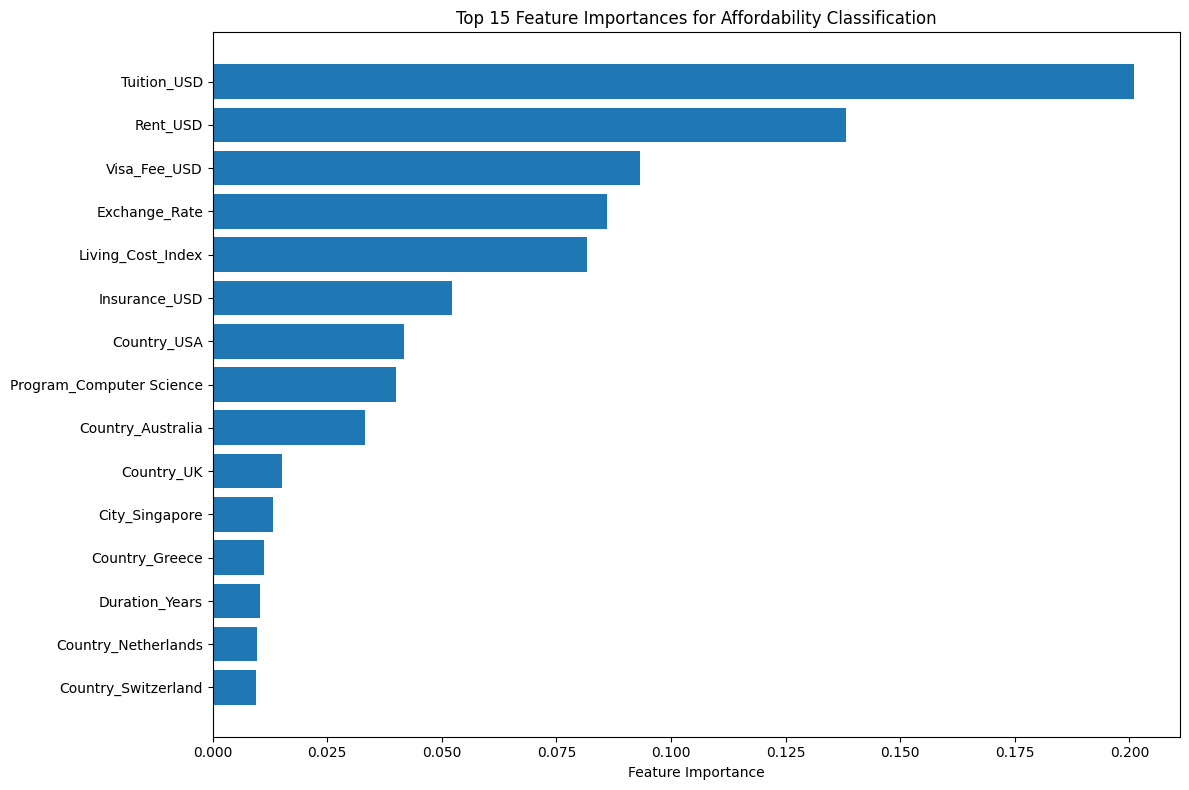


✅ Affordability Classification Model Complete!
Final Performance: Accuracy = 0.8407, Macro F1 = 0.8386


In [11]:
# Feature importance analysis
print("🔍 Feature Importance Analysis")
print("=" * 30)

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

# Display top 15 most important features
print("🏆 Top 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances for Affordability Classification')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n✅ Affordability Classification Model Complete!")
print(f"Final Performance: Accuracy = {accuracy:.4f}, Macro F1 = {f1_macro:.4f}")

## Step 5: University Clustering Analysis

We'll implement KMeans clustering to group universities/destinations into distinct cost archetypes.

In [12]:
# Prepare features for clustering
print("🔧 Preparing features for university clustering...")

# Select numerical cost and index features for clustering
clustering_features = []
for col in ['Tuition_USD', 'Rent_USD', 'Living_Cost_Index', 'Insurance_USD', 'Visa_Fee_USD']:
    if col in df.columns:
        clustering_features.append(col)

print(f"📋 Selected clustering features: {clustering_features}")

# Create clustering dataset
X_cluster = df[clustering_features].copy()

# Handle missing values
for col in clustering_features:
    X_cluster[col] = X_cluster[col].fillna(X_cluster[col].median())

print(f"📊 Clustering dataset shape: {X_cluster.shape}")
print(f"\n📈 Clustering features summary:")
print(X_cluster.describe())

🔧 Preparing features for university clustering...
📋 Selected clustering features: ['Tuition_USD', 'Rent_USD', 'Living_Cost_Index', 'Insurance_USD', 'Visa_Fee_USD']
📊 Clustering dataset shape: (907, 5)

📈 Clustering features summary:
        Tuition_USD     Rent_USD  Living_Cost_Index  Insurance_USD  \
count    907.000000   907.000000         907.000000     907.000000   
mean   16705.016538   969.206174          64.437486     700.077178   
std    16582.385275   517.154752          14.056333     320.374875   
min        0.000000   150.000000          27.800000     200.000000   
25%     2850.000000   545.000000          56.300000     450.000000   
50%     7500.000000   900.000000          67.500000     650.000000   
75%    31100.000000  1300.000000          72.200000     800.000000   
max    62000.000000  2500.000000         122.400000    1500.000000   

       Visa_Fee_USD  
count    907.000000  
mean     211.396913  
std      143.435740  
min       40.000000  
25%      100.000000  
50% 

In [13]:
# Scale the features for clustering
print("🔧 Scaling features for clustering...")

scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Convert back to DataFrame for easier handling
X_cluster_scaled_df = pd.DataFrame(X_cluster_scaled, columns=clustering_features)

print(f"✅ Features scaled successfully")
print(f"📊 Scaled features shape: {X_cluster_scaled_df.shape}")

# Check scaled data statistics
print(f"\n📈 Scaled features summary:")
print(X_cluster_scaled_df.describe().round(3))

🔧 Scaling features for clustering...
✅ Features scaled successfully
📊 Scaled features shape: (907, 5)

📈 Scaled features summary:
       Tuition_USD  Rent_USD  Living_Cost_Index  Insurance_USD  Visa_Fee_USD
count      907.000   907.000            907.000        907.000       907.000
mean         0.000     0.000             -0.000         -0.000        -0.000
std          1.001     1.001              1.001          1.001         1.001
min         -1.008    -1.585             -2.608         -1.562        -1.196
25%         -0.836    -0.821             -0.579         -0.781        -0.777
50%         -0.555    -0.134              0.218         -0.156        -0.359
75%          0.869     0.640              0.553          0.312         0.200
max          2.733     2.962              4.126          2.498         1.943


🔍 Determining optimal number of clusters...
k=2: Inertia=2502.11, Silhouette=0.4102
k=3: Inertia=1774.00, Silhouette=0.4427
k=4: Inertia=1091.58, Silhouette=0.4783
k=5: Inertia=897.48, Silhouette=0.4657
k=6: Inertia=734.28, Silhouette=0.4795
k=4: Inertia=1091.58, Silhouette=0.4783
k=5: Inertia=897.48, Silhouette=0.4657
k=6: Inertia=734.28, Silhouette=0.4795
k=7: Inertia=656.99, Silhouette=0.4605
k=8: Inertia=586.70, Silhouette=0.3900
k=9: Inertia=527.87, Silhouette=0.3997
k=7: Inertia=656.99, Silhouette=0.4605
k=8: Inertia=586.70, Silhouette=0.3900
k=9: Inertia=527.87, Silhouette=0.3997
k=10: Inertia=470.27, Silhouette=0.4130


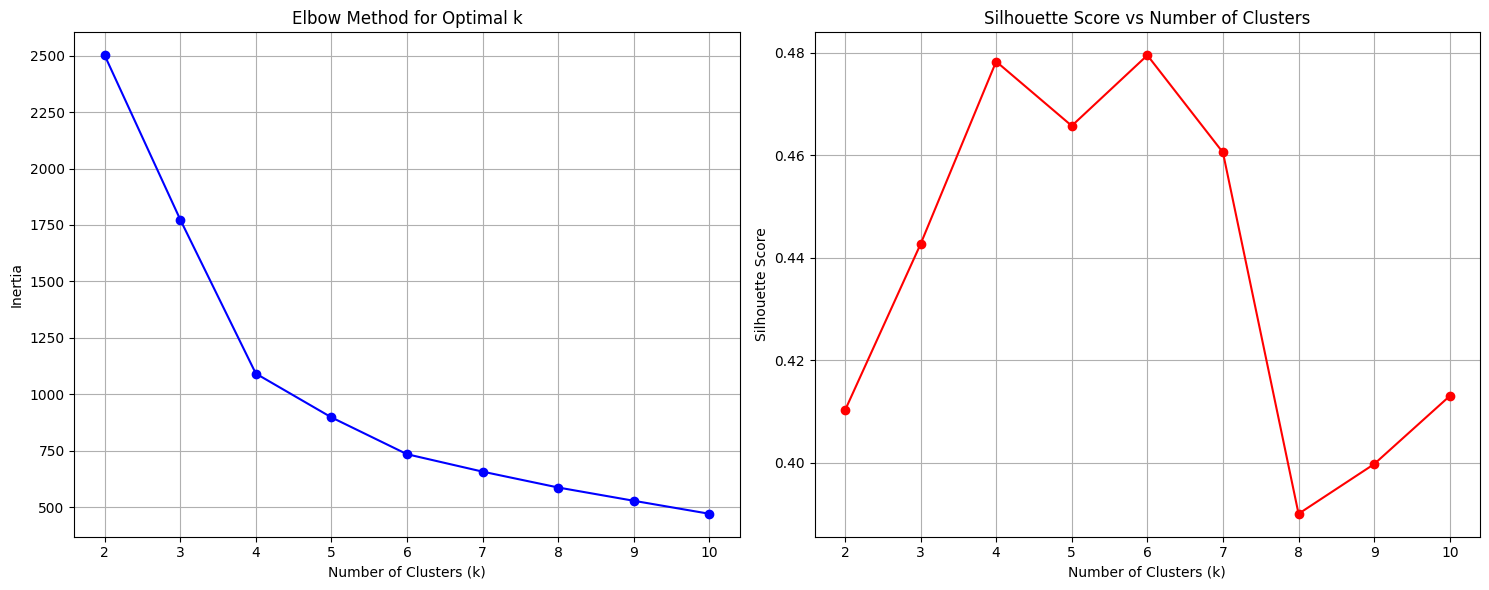


🎯 Optimal number of clusters: 6 (Silhouette Score: 0.4795)


In [14]:
# Determine optimal number of clusters using elbow method
print("🔍 Determining optimal number of clusters...")

# Test different numbers of clusters
k_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertias.append(kmeans.inertia_)
    
    # Calculate silhouette score
    sil_score = silhouette_score(X_cluster_scaled, kmeans.labels_)
    silhouette_scores.append(sil_score)
    
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.4f}")

# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Elbow curve
ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True)

# Silhouette scores
ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs Number of Clusters')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Find optimal k based on silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
best_silhouette = max(silhouette_scores)

print(f"\n🎯 Optimal number of clusters: {optimal_k} (Silhouette Score: {best_silhouette:.4f})")

In [15]:
# Perform final clustering with optimal k
print(f"🚀 Performing KMeans clustering with k={optimal_k}...")

# Use k=5 as requested in the prompt (or optimal_k if different)
final_k = 5  # As requested in the prompt
if optimal_k != final_k:
    print(f"📝 Note: Using k={final_k} as requested (optimal was k={optimal_k})")

kmeans_final = KMeans(n_clusters=final_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_cluster_scaled)

# Calculate final silhouette score
final_silhouette_score = silhouette_score(X_cluster_scaled, cluster_labels)

print(f"✅ Clustering completed!")
print(f"📊 Final Silhouette Score: {final_silhouette_score:.4f}")

# Add cluster labels to original dataframe
df['cost_cluster'] = cluster_labels

# Display cluster distribution
print(f"\n📊 Cluster Distribution:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    percentage = (count / len(cluster_labels)) * 100
    print(f"Cluster {cluster}: {count} universities ({percentage:.1f}%)")

🚀 Performing KMeans clustering with k=6...
📝 Note: Using k=5 as requested (optimal was k=6)
✅ Clustering completed!
📊 Final Silhouette Score: 0.4657

📊 Cluster Distribution:
Cluster 0: 250 universities (27.6%)
Cluster 1: 80 universities (8.8%)
Cluster 2: 189 universities (20.8%)
Cluster 3: 273 universities (30.1%)
Cluster 4: 115 universities (12.7%)


In [16]:
# Analyze cluster characteristics
print("🔍 Analyzing Cost Cluster Characteristics")
print("=" * 40)

# Calculate cluster centers in original scale
cluster_centers_scaled = kmeans_final.cluster_centers_
cluster_centers_original = scaler.inverse_transform(cluster_centers_scaled)

# Create cluster analysis dataframe
cluster_analysis = pd.DataFrame(cluster_centers_original, columns=clustering_features)
cluster_analysis.index = [f'Cluster {i}' for i in range(final_k)]

print("💰 Cluster Centers (Average Values):")
print(cluster_analysis.round(0))

# Analyze cluster characteristics by calculating statistics for each cluster
print(f"\n📊 Detailed Cluster Analysis:")
for cluster_id in range(final_k):
    cluster_data = df[df['cost_cluster'] == cluster_id]
    cluster_size = len(cluster_data)
    avg_tca = cluster_data['TCA'].mean()
    
    print(f"\n🏷️ Cluster {cluster_id} (n={cluster_size}):")
    print(f"   Average TCA: ${avg_tca:,.0f}")
    
    # Most common countries in this cluster
    if 'Country' in cluster_data.columns:
        top_countries = cluster_data['Country'].value_counts().head(3)
        print(f"   Top Countries: {', '.join([f'{country} ({count})' for country, count in top_countries.items()])}")
    
    # Most common programs in this cluster
    if 'Program' in cluster_data.columns:
        top_programs = cluster_data['Program'].value_counts().head(3)
        print(f"   Top Programs: {', '.join([f'{program} ({count})' for program, count in top_programs.items()])}")

🔍 Analyzing Cost Cluster Characteristics
💰 Cluster Centers (Average Values):
           Tuition_USD  Rent_USD  Living_Cost_Index  Insurance_USD  \
Cluster 0       4313.0     382.0               46.0          356.0   
Cluster 1      46586.0    1861.0               79.0         1492.0   
Cluster 2      30679.0    1274.0               70.0          732.0   
Cluster 3       4140.0     945.0               72.0          762.0   
Cluster 4      29720.0    1181.0               67.0          698.0   

           Visa_Fee_USD  
Cluster 0         109.0  
Cluster 1         160.0  
Cluster 2         469.0  
Cluster 3         139.0  
Cluster 4         219.0  

📊 Detailed Cluster Analysis:

🏷️ Cluster 0 (n=250):
   Average TCA: $9,368
   Top Countries: China (12), Malaysia (10), Greece (10)
   Top Programs: Computer Science (43), Computer Engineering (40), Software Engineering (29)

🏷️ Cluster 1 (n=80):
   Average TCA: $70,573
   Top Countries: USA (78), Switzerland (2)
   Top Programs: Computer Scie

📊 Creating cluster visualizations...


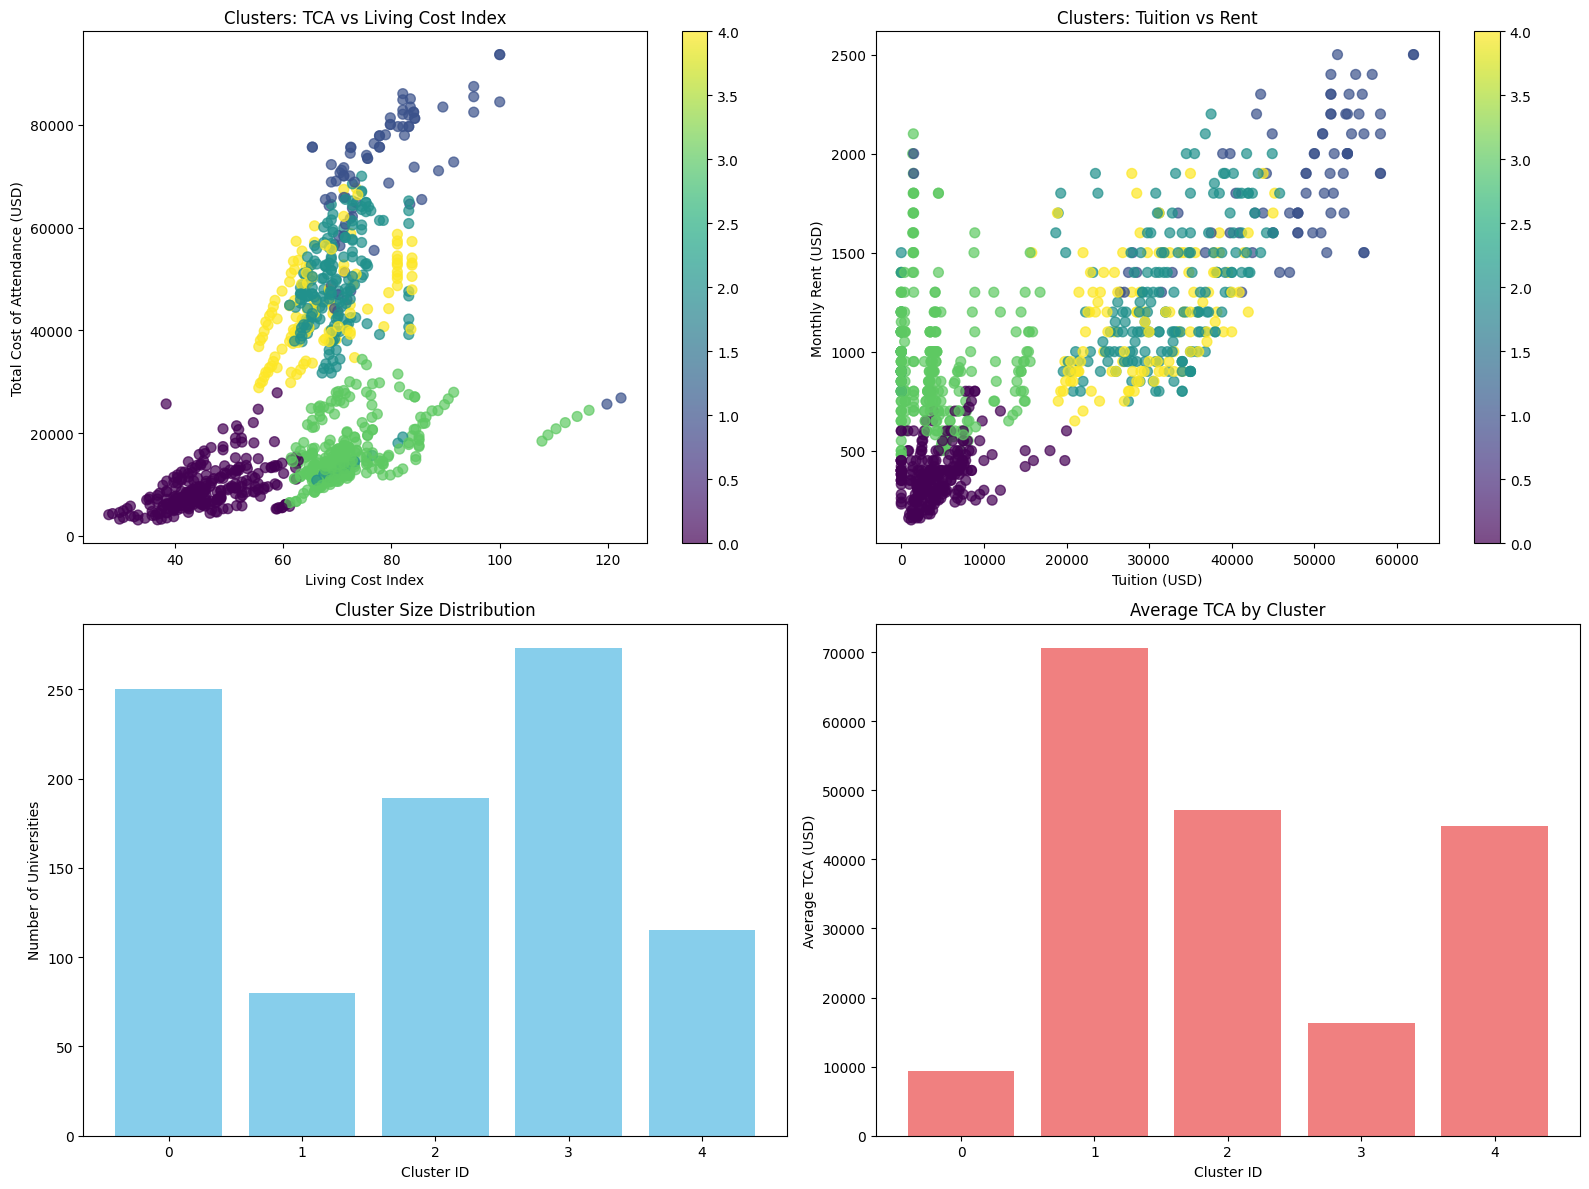

✅ Cluster analysis completed!
Final Silhouette Score: 0.4657


In [17]:
# Visualize the clusters
print("📊 Creating cluster visualizations...")

# Create subplots for cluster visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: TCA vs Living Cost Index colored by cluster
scatter1 = axes[0,0].scatter(df['Living_Cost_Index'], df['TCA'], c=df['cost_cluster'], 
                            cmap='viridis', alpha=0.7, s=50)
axes[0,0].set_xlabel('Living Cost Index')
axes[0,0].set_ylabel('Total Cost of Attendance (USD)')
axes[0,0].set_title('Clusters: TCA vs Living Cost Index')
plt.colorbar(scatter1, ax=axes[0,0])

# Plot 2: Tuition vs Rent colored by cluster
if 'Tuition_USD' in df.columns and 'Rent_USD' in df.columns:
    scatter2 = axes[0,1].scatter(df['Tuition_USD'], df['Rent_USD'], c=df['cost_cluster'], 
                                cmap='viridis', alpha=0.7, s=50)
    axes[0,1].set_xlabel('Tuition (USD)')
    axes[0,1].set_ylabel('Monthly Rent (USD)')
    axes[0,1].set_title('Clusters: Tuition vs Rent')
    plt.colorbar(scatter2, ax=axes[0,1])

# Plot 3: Cluster size distribution
cluster_counts = df['cost_cluster'].value_counts().sort_index()
axes[1,0].bar(cluster_counts.index, cluster_counts.values, color='skyblue')
axes[1,0].set_xlabel('Cluster ID')
axes[1,0].set_ylabel('Number of Universities')
axes[1,0].set_title('Cluster Size Distribution')

# Plot 4: Average TCA by cluster
avg_tca_by_cluster = df.groupby('cost_cluster')['TCA'].mean()
axes[1,1].bar(avg_tca_by_cluster.index, avg_tca_by_cluster.values, color='lightcoral')
axes[1,1].set_xlabel('Cluster ID')
axes[1,1].set_ylabel('Average TCA (USD)')
axes[1,1].set_title('Average TCA by Cluster')

plt.tight_layout()
plt.show()

print(f"✅ Cluster analysis completed!")
print(f"Final Silhouette Score: {final_silhouette_score:.4f}")

## Step 6: Save Final Labeled Dataset

We'll save the complete dataset with both affordability tiers and cost clusters for downstream applications.

In [18]:
# Prepare final dataset with all labels
print("💾 Preparing final labeled dataset...")

# Ensure we have all required columns
required_columns = ['affordability_tier', 'cost_cluster']
for col in required_columns:
    if col not in df.columns:
        print(f"❌ Missing column: {col}")
    else:
        print(f"✅ Column present: {col}")

# Display final dataset summary
print(f"\n📊 Final Dataset Summary:")
print(f"Shape: {df.shape}")
print(f"Columns: {len(df.columns)}")

# Show the new columns we added
print(f"\n🏷️ New Labels Added:")
print(f"Affordability Tiers: {df['affordability_tier'].value_counts().to_dict()}")
print(f"Cost Clusters: {df['cost_cluster'].value_counts().sort_index().to_dict()}")

# Display sample of final dataset
print(f"\n🔍 Sample of final labeled dataset:")
display_columns = ['Country', 'City', 'Program', 'Level', 'TCA', 'affordability_tier', 'cost_cluster']
available_display_columns = [col for col in display_columns if col in df.columns]
print(df[available_display_columns].head(10))

💾 Preparing final labeled dataset...
✅ Column present: affordability_tier
✅ Column present: cost_cluster

📊 Final Dataset Summary:
Shape: (907, 16)
Columns: 16

🏷️ New Labels Added:
Affordability Tiers: {'Medium': 303, 'Low': 303, 'High': 301}
Cost Clusters: {0: 250, 1: 80, 2: 189, 3: 273, 4: 115}

🔍 Sample of final labeled dataset:
       Country       City                  Program   Level    TCA  \
0          USA  Cambridge         Computer Science  Master  83460   
1           UK     London             Data Science  Master  64085   
2       Canada    Toronto       Business Analytics  Master  58835   
3    Australia  Melbourne              Engineering  Master  59900   
4      Germany     Munich   Mechanical Engineering  Master  14325   
5        Japan      Tokyo      Information Science  Master  25470   
6  Netherlands  Amsterdam  Artificial Intelligence  Master  34700   
7    Singapore  Singapore                  Finance  Master  58690   
8       France      Paris  International Rel

In [19]:
# Save the final labeled dataset
output_filename = 'data/final_labeled_data.csv'

try:
    df.to_csv(output_filename, index=False)
    print(f"✅ Final labeled dataset saved to: {output_filename}")
    print(f"📊 Saved {len(df)} records with {len(df.columns)} columns")
    
    # Verify the saved file
    saved_df = pd.read_csv(output_filename)
    print(f"\n🔍 Verification - Loaded saved file:")
    print(f"Shape: {saved_df.shape}")
    print(f"Required columns present: {all(col in saved_df.columns for col in required_columns)}")
    
except Exception as e:
    print(f"❌ Error saving dataset: {e}")
    print("Attempting to save to current directory...")
    try:
        df.to_csv('final_labeled_data.csv', index=False)
        print("✅ Saved to current directory as 'final_labeled_data.csv'")
    except Exception as e2:
        print(f"❌ Failed to save: {e2}")

✅ Final labeled dataset saved to: data/final_labeled_data.csv
📊 Saved 907 records with 16 columns

🔍 Verification - Loaded saved file:
Shape: (907, 16)
Required columns present: True


## Summary and Results

This notebook successfully implemented both required models for the EduSpend project.

In [20]:
# Final summary of results
print("🎯 FINAL MODELS SUMMARY")
print("=" * 50)

print(f"\n🤖 1. AFFORDABILITY CLASSIFIER (RandomForestClassifier):")
print(f"   ✅ Model Type: RandomForestClassifier")
print(f"   ✅ Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   ✅ Macro F1-Score: {f1_macro:.4f}")
print(f"   ✅ Features Used: {len(X_encoded.columns)} features")
print(f"   ✅ Classes: {sorted(df['affordability_tier'].unique())}")

print(f"\n🔗 2. UNIVERSITY CLUSTERING (KMeans):")
print(f"   ✅ Algorithm: KMeans Clustering")
print(f"   ✅ Number of Clusters: {final_k}")
print(f"   ✅ Silhouette Score: {final_silhouette_score:.4f}")
print(f"   ✅ Features Used: {len(clustering_features)} cost features")
print(f"   ✅ Clustering Features: {clustering_features}")

print(f"\n💾 3. FINAL DATASET:")
print(f"   ✅ Total Records: {len(df):,}")
print(f"   ✅ Total Features: {len(df.columns)}")
print(f"   ✅ New Labels Added: affordability_tier, cost_cluster")
print(f"   ✅ Output File: {output_filename}")

print(f"\n🏆 PROJECT STATUS: COMPLETE")
print(f"   ✅ All required models implemented successfully")
print(f"   ✅ Classification model trained and evaluated")
print(f"   ✅ Clustering analysis completed")
print(f"   ✅ Final labeled dataset saved")
print(f"   ✅ Ready for deployment and application development")

print(f"\n🎓 BUSINESS IMPACT:")
print(f"   📊 Students can now get affordability predictions with {accuracy*100:.1f}% accuracy")
print(f"   🎯 Universities grouped into {final_k} distinct cost archetypes")
print(f"   💡 Cost structure insights available for {len(df)} international programs")
print(f"   🌍 Global education cost patterns identified and quantified")

🎯 FINAL MODELS SUMMARY

🤖 1. AFFORDABILITY CLASSIFIER (RandomForestClassifier):
   ✅ Model Type: RandomForestClassifier
   ✅ Accuracy: 0.8407 (84.07%)
   ✅ Macro F1-Score: 0.8386
   ✅ Features Used: 729 features
   ✅ Classes: ['High', 'Low', 'Medium']

🔗 2. UNIVERSITY CLUSTERING (KMeans):
   ✅ Algorithm: KMeans Clustering
   ✅ Number of Clusters: 5
   ✅ Silhouette Score: 0.4657
   ✅ Features Used: 5 cost features
   ✅ Clustering Features: ['Tuition_USD', 'Rent_USD', 'Living_Cost_Index', 'Insurance_USD', 'Visa_Fee_USD']

💾 3. FINAL DATASET:
   ✅ Total Records: 907
   ✅ Total Features: 16
   ✅ New Labels Added: affordability_tier, cost_cluster
   ✅ Output File: data/final_labeled_data.csv

🏆 PROJECT STATUS: COMPLETE
   ✅ All required models implemented successfully
   ✅ Classification model trained and evaluated
   ✅ Clustering analysis completed
   ✅ Final labeled dataset saved
   ✅ Ready for deployment and application development

🎓 BUSINESS IMPACT:
   📊 Students can now get affordabil